# Project 6 - Neural Radiance Fields

### Dependencies

In [1]:
from torch.utils.data import Dataset, DataLoader
from typing import Dict, Any, List
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
import numpy as np
import torch
from tqdm import tqdm

## Part 1 - Fit a Neural Field to a 2D image

In [2]:
# Check device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Implement Network

In [3]:
class Multi_Layer_Perceptron(nn.Module):
    def __init__(self, channel_size: int = 256, L: int = 10):
        super(Multi_Layer_Perceptron, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(4*L+2, channel_size),
            nn.ReLU(),
            nn.Linear(channel_size, channel_size),
            nn.ReLU(),
            nn.Linear(channel_size, channel_size),
            nn.ReLU(),
            nn.Linear(channel_size, 3),
            nn.Sigmoid()
        )
        self.L = L

    def forward(self, x):
        x = self.get_PE(x)
        out = self.mlp(x)
        return out

    def get_PE(self, x):
        # Efficient Positional Encoding
        x_dims = torch.hstack([torch.sin(((2**i)*np.pi)*x) for i in range(self.L)])
        y_dims = torch.hstack([torch.cos(((2**i)*np.pi)*x) for i in range(self.L)])
        x_PE = torch.hstack((x, x_dims, y_dims))
        return x_PE

### Implement Dataloader

In [4]:
# class NeRF_Dataset(Dataset):
class RandomPixelSampler(Dataset):
    """Samples random pixels from image for coordinate-based representation"""
    def __init__(self, image, N: int = 10000, numIt: int = 2000):
        self.N = N
        self.numIt = numIt
        self.image = image

    def __len__(self):
        return self.numIt

    def __getitem__(self, idx):
        N, M, _ = self.image.shape
        random_indices = torch.randint(0, N*M, (self.N,))
        row_indices = random_indices // M
        col_indices = random_indices % M
        pixel_coords = torch.stack((row_indices/N, col_indices/M), dim=1)
        pixel_vals = self.image[row_indices, col_indices, :]
        return pixel_coords, pixel_vals

### Implement Loss Function, Optimizer, and Metric

In [5]:
def get_reconstruction_image(model, image_shape):
    model.eval()
    N, M, _ = image_shape
    with torch.no_grad():
        row_coords, col_coords = torch.meshgrid(torch.arange(N), torch.arange(M), indexing='ij')
        pixel_coords = torch.stack((row_coords/N, col_coords/M), dim=2)
        img = model(pixel_coords.reshape(N*M, 2).to(device)).reshape(N, M, 3).cpu().numpy()
    return img

def train_model(
    model, 
    train_loader, 
    image_shape, 
    num_iterations: int = 2000, 
    learning_rate: float = 1e-2
):
    losses = []
    reconstruction_images = []

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Iterations to save reconstruction progress
    progress_steps = [1, 20, 100, 500, 1000, 2000]

    for i, (inputs, labels) in enumerate(tqdm(train_loader), 1):
        # Save reconstruction images at specific steps
        if i in progress_steps:
            reconstruction_images.append(get_reconstruction_image(model, image_shape))
        
        inputs = inputs[0].to(device)
        labels = labels[0].to(device)
        
        # Compute PSNR as loss
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = 10 * torch.log10(nn.functional.mse_loss(outputs.float(), labels.float()))
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if i == num_iterations:
            break

    return losses, reconstruction_images

### Implement Hyperparameter Tuning

In [6]:
def plot_reconstructions(images):
    fig, axes = plt.subplots(1, len(images), figsize=(30, 30))
    plt.subplots_adjust(wspace=0.05)
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

def run_experiment(image_path, channel_size: int = 256, L: int = 10, learning_rate: float = 1e-2):
    # Load image
    img = Image.open(image_path)
    image = np.array(img) / 255.0  # Normalize the image to [0, 1] range
    
    # Create dataset and dataloader
    dataset = RandomPixelSampler(image)
    dataloader = DataLoader(dataset)
    
    # Initialize and train model
    model = Multi_Layer_Perceptron(channel_size = channel_size, L = L).to(device)
    losses, reconstructions = train_model(model, dataloader, image.shape, learning_rate=learning_rate)
    
    # Visualize results
    plot_reconstructions(reconstructions)
    
    return model, losses, reconstructions

def compare_configurations(image_path: str):
    """Compare different model configurations"""
    
    configs = {
        'base': {
            'channel_size': 256,
            'learning_rate': 1e-2,
            'L': 10
        },
        'reduced_freq': {
            'channel_size': 256,
            'learning_rate': 1e-2,
            'L': 3                # Reduced frequency
        },
        'wider': {
            'channel_size': 512,  # Double channel size
            'learning_rate': 1e-2,
            'L': 10
        },
        'higher_lr': {
            'channel_size': 256,
            'learning_rate': 1e-1,  # Higher learning rate
            'L': 10
        },
    }
    
    results = {}
    for name, config in configs.items():
        print(f"\nTraining {name} configuration...")
        model, losses, reconstructions = run_experiment(
            image_path, 
            channel_size=config['channel_size'], 
            L=config['L'],
            learning_rate=config['learning_rate']
        )
        results[name] = losses
        print(f"Final PSNR: {-losses[-1]:.2f}")  # Note the negative PSNR due to the log scale
    
    # Plot results
    plt.figure(figsize=(10, 6))
    for name, losses in results.items():
        plt.plot(range(1, len(losses) + 1), -np.array(losses), label=name)
    plt.xlabel('Iteration')
    plt.ylabel('PSNR')
    plt.title('PSNR vs Iteration for Different Configurations')
    plt.legend()
    plt.grid(True)
    plt.show()

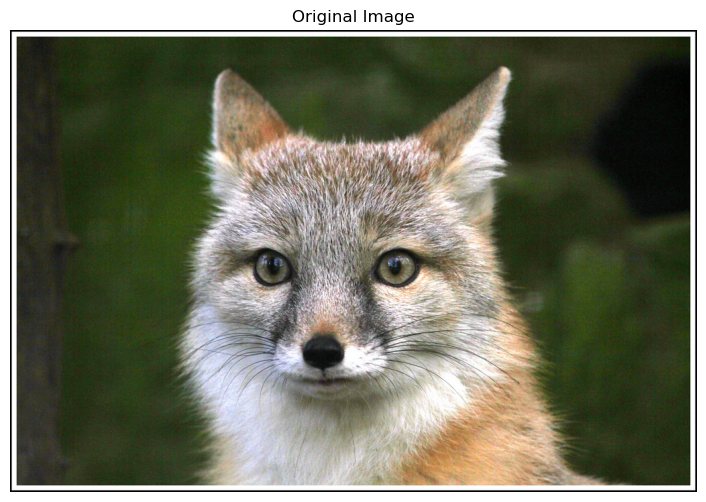


Training base configuration...


100%|█████████▉| 1999/2000 [06:32<00:00,  5.09it/s]


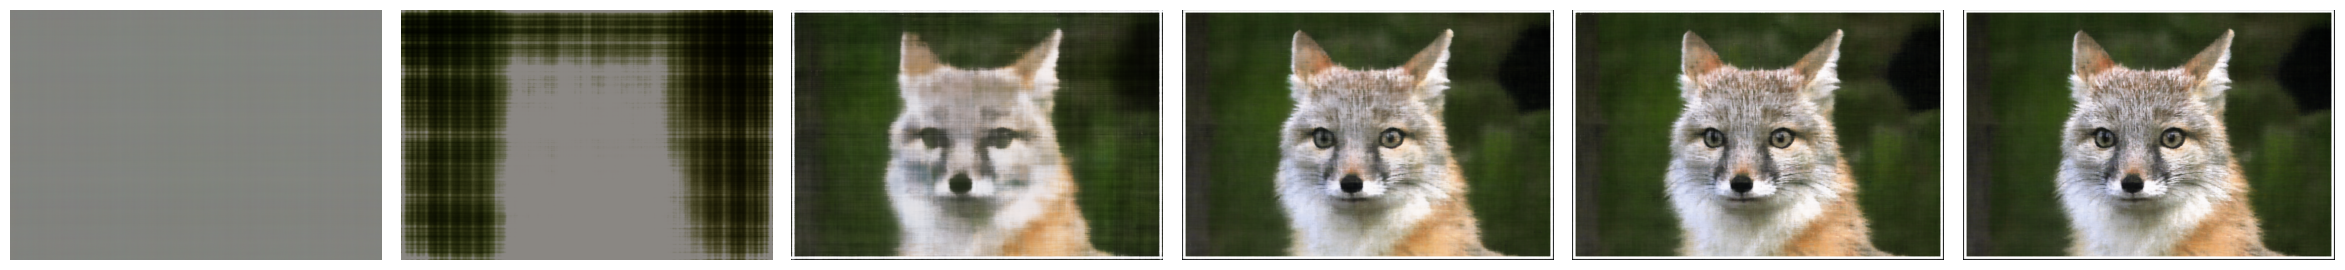

Final PSNR: 26.79

Training reduced_freq configuration...


100%|█████████▉| 1999/2000 [05:47<00:00,  5.76it/s]


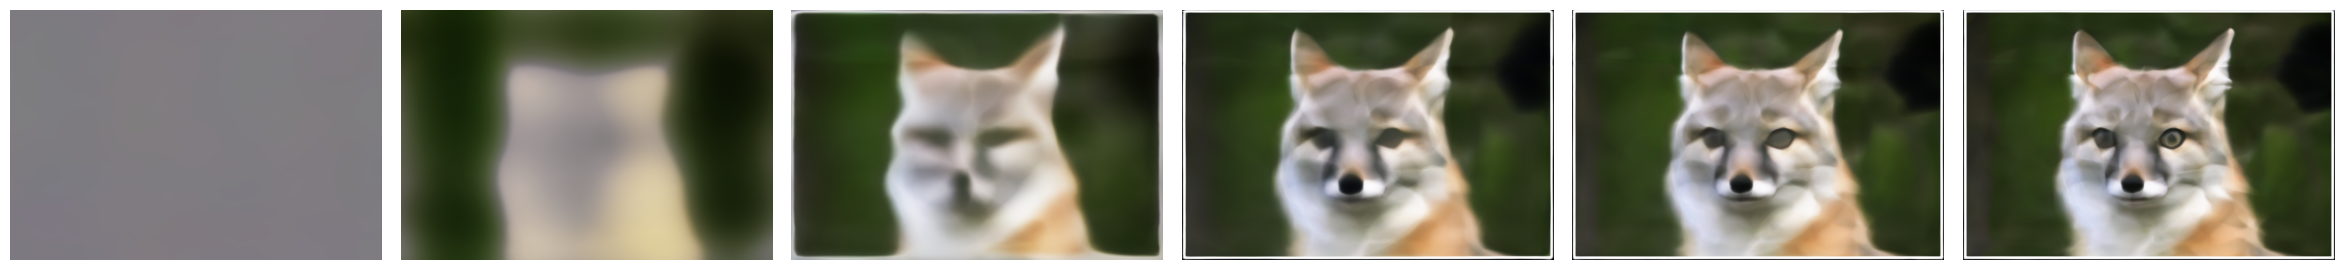

Final PSNR: 24.84

Training wider configuration...


100%|█████████▉| 1999/2000 [11:34<00:00,  2.88it/s]


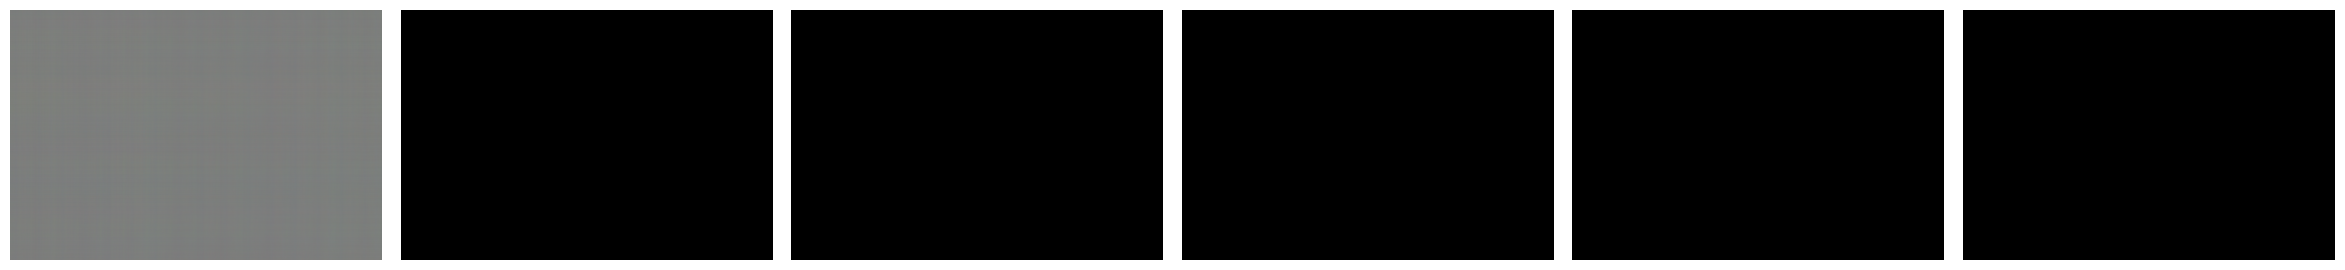

Final PSNR: 6.61

Training higher_lr configuration...


100%|█████████▉| 1999/2000 [05:22<00:00,  6.20it/s]


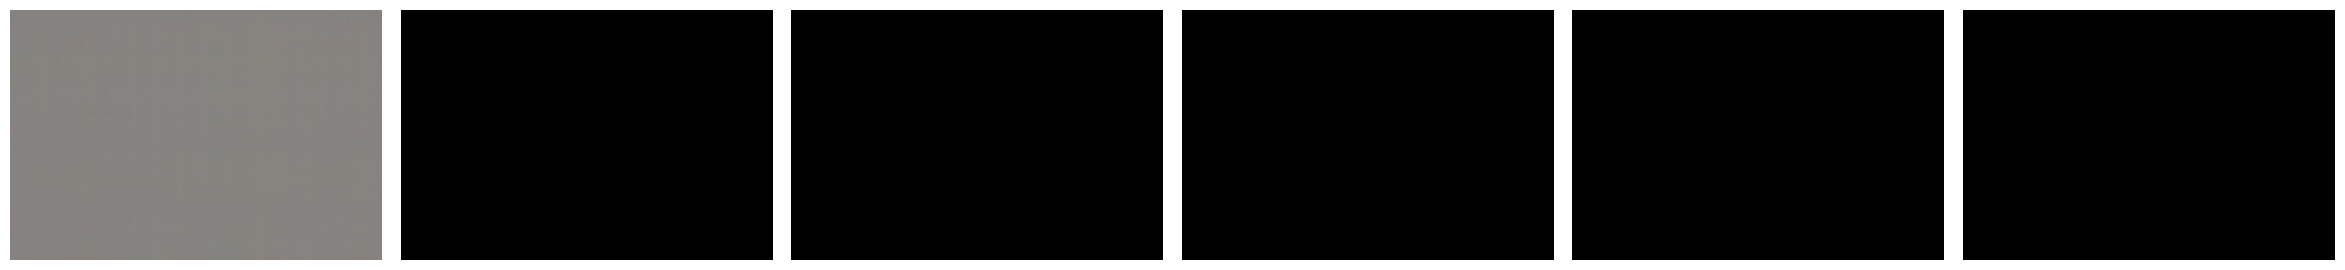

Final PSNR: 6.54


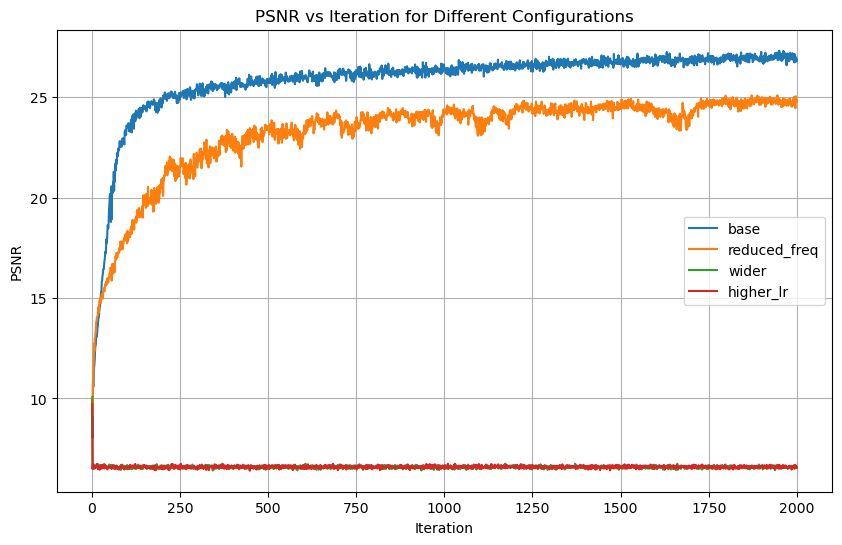

In [7]:
# Set image path
image_path = "../data/fox.jpg"

# Display original image
img = Image.open(image_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Visualization for final reconstruction
def visualize_reconstruction(model, image_path):
    """Visualize the reconstructed image"""
    img = Image.open(image_path)
    width, height = img.size
    
    x_coords = np.linspace(0, 1, width)
    y_coords = np.linspace(0, 1, height)
    coords = np.stack(np.meshgrid(x_coords, y_coords), axis=-1)
    
    model.eval()
    with torch.no_grad():
        coords_tensor = torch.FloatTensor(coords).reshape(-1, 2).to(device)
        pred_colors = model(coords_tensor).cpu().numpy()
        pred_image = pred_colors.reshape(height, width, 3)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis('off')
    ax2.imshow(pred_image)
    ax2.set_title("Reconstructed")
    ax2.axis('off')
    plt.show()

# Run configurations comparison
compare_configurations(image_path)

## Part 2: Fit a Neural Radiance Field from Multi-view Images

In [6]:
data = np.load(f"../data/lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

# Intrinsic matrix
sigma = images_train.shape[1] / 2
K = np.array([[focal, 0, sigma],[0, focal, sigma],[0, 0, 1]])

### Part 2.1: Create Rays from Cameras

In [7]:
def transform(c2w,x_c):
  coords_set = np.hstack([x_c,np.ones((x_c.shape[0],1))]).T
  x_w = c2w @ coords_set
  x_w = x_w[:3] / x_w[3]
  return x_w.T

def pixel_to_camera(K, uv, s):
  uv = np.hstack([uv,np.ones((uv.shape[0],1))]).T
  K_inv = np.linalg.inv(K)
  return (K_inv * s @ uv).T

def pixel_to_ray(K, c2w, uv):
  uv = uv + 0.5
  r_o = transform(c2w, np.zeros((uv.shape[0],3)))
  X_c = pixel_to_camera(K,uv, 1)
  X_w = transform(c2w, X_c)
  norm = np.linalg.norm(X_w-r_o, axis=1)
  r_d = (X_w - r_o) / norm.reshape((norm.shape[0],1))
  return r_o, r_d

### Part 2.2: Sampling

In [8]:
def sample_along_rays(rays_o, rays_d, perturb):
    near = 2.0
    far = 6.0
    n_samples = 64
    t = np.linspace(near, far, n_samples)
    if perturb:
      t = t + np.random.rand(n_samples) * 0.1

    X = np.array([rays_o + rays_d*z for z in t])
    return X.swapaxes(0,1)

In [9]:
class RaysData:
    def __init__(self, images, K, c2ws):
        """
        Initialize the RaysData class with training images, camera intrinsics, and camera-to-world transformations.
        
        Args:
        - images (np.ndarray): Training images with shape (N, H, W, 3)
        - K (np.ndarray): Camera intrinsics matrix (3x3)
        - c2ws (np.ndarray): Camera-to-world transformations (N, 4, 4)
        """
        self.images = images
        self.K = K
        self.c2ws = c2ws
        self.H, self.W = images.shape[1:3]
        
        # Precompute inverse of camera intrinsics for ray direction calculation
        self.K_inv = np.linalg.inv(K)
    
    def sample_rays(self, num_rays):
        """
        Sample rays from multiple images.
        
        Args:
        - num_rays (int): Number of rays to sample
        
        Returns:
        - rays_o (np.ndarray): Ray origins of shape (num_rays, 3)
        - rays_d (np.ndarray): Ray directions of shape (num_rays, 3)
        - pixels (np.ndarray): Pixel colors of shape (num_rays, 3)
        """
        # Option 1: Sample from multiple images (as suggested in the instructions)
        # Determine how many rays to sample from each image
        num_images = len(self.images)
        rays_per_image = num_rays // num_images
        extra_rays = num_rays % num_images
        
        rays_o_list = []
        rays_d_list = []
        pixels_list = []
        
        for i, (image, c2w) in enumerate(zip(self.images, self.c2ws)):
            # Determine number of rays for this image
            current_rays = rays_per_image + (1 if i < extra_rays else 0)
            
            # Randomly sample pixel coordinates
            pixel_y = np.random.randint(0, self.H, current_rays)
            pixel_x = np.random.randint(0, self.W, current_rays)
            
            # Add .5 to get pixel center (as specified in instructions)
            u = pixel_x + 0.5
            v = pixel_y + 0.5
            
            # Create homogeneous pixel coordinates
            pixel_coords = np.stack([u, v, np.ones_like(u)], axis=-1)
            
            # Convert pixel coordinates to ray directions in camera coordinates
            ray_dirs_cam = self.K_inv @ pixel_coords.T  # (3, num_rays)
            ray_dirs_cam = ray_dirs_cam / np.linalg.norm(ray_dirs_cam, axis=0)
            ray_dirs_cam = ray_dirs_cam.T  # (num_rays, 3)
            
            # Transform ray directions to world coordinates
            ray_dirs_world = (c2w[:3, :3] @ ray_dirs_cam.T).T
            
            # Compute ray origins (camera center in world coordinates)
            ray_origins = np.tile(c2w[:3, 3], (current_rays, 1))
            
            # Sample pixel colors
            pixel_colors = image[pixel_y, pixel_x]
            
            rays_o_list.append(ray_origins)
            rays_d_list.append(ray_dirs_world)
            pixels_list.append(pixel_colors)
        
        # Concatenate rays from all images
        rays_o = np.concatenate(rays_o_list, axis=0)
        rays_d = np.concatenate(rays_d_list, axis=0)
        pixels = np.concatenate(pixels_list, axis=0)
        
        return rays_o, rays_d, pixels

def sample_along_rays(rays_o, rays_d, near=2.0, far=6.0, n_samples=32, perturb=False):
    """
    Sample points along rays.
    
    Args:
    - rays_o (np.ndarray): Ray origins of shape (num_rays, 3)
    - rays_d (np.ndarray): Ray directions of shape (num_rays, 3)
    - near (float): Near plane distance
    - far (float): Far plane distance
    - n_samples (int): Number of samples along each ray
    - perturb (bool): Whether to add random perturbation to samples
    
    Returns:
    - points (np.ndarray): 3D points sampled along rays of shape (num_rays, n_samples, 3)
    """
    # Create uniform samples along ray
    t_vals = np.linspace(near, far, n_samples)
    
    # Add random perturbation if specified (only during training)
    if perturb:
        t_width = (far - near) / (n_samples - 1)
        t_vals = t_vals + (np.random.rand(n_samples) * t_width)
    
    # Broadcast t_vals to match number of rays
    t_vals = np.tile(t_vals, (rays_o.shape[0], 1))
    
    # Compute 3D points along rays
    points = rays_o[:, np.newaxis, :] + rays_d[:, np.newaxis, :] * t_vals[:, :, np.newaxis]
    
    return points

### Part 2.3: Putting the Dataloading All Together

In [10]:
import viser, time  # pip install viser
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(100) # Should expect (B, 3)
points = sample_along_rays(rays_o, rays_d, perturb=True)
H, W = images_train.shape[1:3]
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.scene.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.scene.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.scene.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)
time.sleep(1)

╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8081   │
│   Websocket │ ws://localhost:8081     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 32 clients): https://stiff-separated.share.viser.studio

### Part 2.4: Neural Radiance Field

In [11]:
class NeRF(nn.Module):
  def __init__(self):
    super(NeRF, self).__init__()
    self.centerMLP1 = nn.Sequential(
        nn.Linear(63, 256),
        nn.ReLU(),
        nn.Linear(256,256),
        nn.ReLU(),
        nn.Linear(256,256),
        nn.ReLU(),
        nn.Linear(256,256),
        nn.ReLU(),
    )

    self.centerMLP2 = nn.Sequential(
        nn.Linear(319,256),
        nn.ReLU(),
        nn.Linear(256,256),
        nn.ReLU(),
        nn.Linear(256,256),
        nn.ReLU(),
        nn.Linear(256,256)
    )

    self.densityMLP = nn.Sequential(
        nn.Linear(256,1),
        nn.ReLU(),
    )

    self.rgbMLP1 = nn.Linear(256,256)
    self.rgbMLP2 = nn.Sequential(
        nn.Linear(283,128),
        nn.ReLU(),
        nn.Linear(128,3),
        nn.Sigmoid()
    )

  def forward(self,x,r_d):
    B,N,_ = x.size()
    x = self.get_PE(x,10)
    r_d = self.get_PE(r_d,4)
    # Feed forward
    x = torch.cat([self.centerMLP1(x),x],dim =-1)
    x = self.centerMLP2(x)

    # Go through density branch
    density = self.densityMLP(x)

    # Go through RGB branch
    rgb = self.rgbMLP1(x)
    r_d = r_d.unsqueeze(1).repeat(1,N,1)
    rgb = torch.cat([rgb,r_d], dim=-1)
    rgb = self.rgbMLP2(rgb)

    # Volume Rendering
    step_size = (6.0 - 2.0) / 64
    return self.volrend(density,rgb,step_size)

  def get_PE(self, x, L):
    sin_dims = torch.cat([torch.sin(((2**i)*np.pi)*x) for i in range(L)],dim=-1)
    cos_dims = torch.cat([torch.cos(((2**i)*np.pi)*x) for i in range(L)],dim=-1)
    x_PE = torch.cat([x,sin_dims, cos_dims],dim=-1)
    return x_PE

  def volrend(self, sigmas, rgbs, step_size):
    B = sigmas.size(0)
    sigmas = torch.cat([torch.zeros(B,1,1).to(device),sigmas],dim=1)
    T_i = torch.exp(-torch.cumsum(sigmas[:,:-1,:], dim=1)*step_size)
    exp_term = 1-torch.exp(-sigmas[:,1:,:]*step_size)
    #prod = T_i * exp_term * torch.linspace(1,0,64).unsqueeze(0).unsqueeze(2).repeat(B,1,1).to(device) #depth rendering
    prod = T_i * exp_term * rgbs
    rend = torch.sum(prod, dim=1)
    color = torch.Tensor([0,0.667,1]).to(device)
    rend = rend + (1-torch.sum(T_i*exp_term,dim=1))*color # bg color
    return rend

### Part 2.5: Volume Rendering

In [12]:
def volrend(sigmas, rgbs, step_size):
    """
    Perform volume rendering on a batch of rays.
    
    Args:
    - sigmas (torch.Tensor): Density values of shape (num_rays, num_samples, 1)
    - rgbs (torch.Tensor): Color values of shape (num_rays, num_samples, 3)
    - step_size (float): Size of each sampling interval
    
    Returns:
    - rendered_colors (torch.Tensor): Rendered colors of shape (num_rays, 3)
    """
    # Flatten sigmas and rgbs if needed
    sigmas = sigmas.squeeze(-1)  # (num_rays, num_samples)
    
    # Compute the accumulated transmittance
    # T_i = exp(-sum(sigma_j * delta_j)) for j < i
    transmittance = torch.exp(-torch.cumsum(sigmas * step_size, dim=-1))
    
    # Shift transmittance to compute per-interval transmittance
    # First interval starts with full transmittance (1.0)
    shifted_transmittance = torch.roll(transmittance, 1, dims=-1)
    shifted_transmittance[..., 0] = 1.0
    
    # Compute termination probability at each interval
    # 1 - exp(-sigma * delta)
    termination_prob = 1.0 - torch.exp(-sigmas * step_size)
    
    # Compute weights for each sample
    weights = shifted_transmittance * termination_prob
    
    # Render colors by weighted sum
    rendered_colors = torch.sum(weights[..., None] * rgbs, dim=-2)
    
    return rendered_colors

### Test Volume Rendering

In [13]:
import torch
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1))
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(sigmas, rgbs, step_size)

correct = torch.tensor([
    [0.5006, 0.3728, 0.4728],
    [0.4322, 0.3559, 0.4134],
    [0.4027, 0.4394, 0.4610],
    [0.4514, 0.3829, 0.4196],
    [0.4002, 0.4599, 0.4103],
    [0.4471, 0.4044, 0.4069],
    [0.4285, 0.4072, 0.3777],
    [0.4152, 0.4190, 0.4361],
    [0.4051, 0.3651, 0.3969],
    [0.3253, 0.3587, 0.4215]
  ])
assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)

## Train NeRF